In [1]:
# -*- coding: utf-8 -*-
import os, math, random, re, cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import shapely.wkt
from osgeo import ogr
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point, MultiPoint, LinearRing
from tqdm import tqdm_notebook
%matplotlib inline

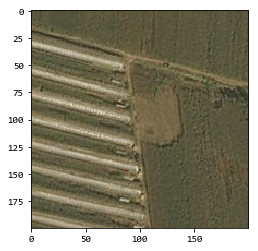

In [2]:
dapeng_ensure = cv2.imread("dapeng_ensure.png", cv2.IMREAD_GRAYSCALE)
dapeng = cv2.imread("dapeng.png")[:dapeng_ensure.shape[0], :dapeng_ensure.shape[1]]
partial_vision = (slice(1000, 1200), slice(3200, 3400))
plt.imshow(cv2.cvtColor(dapeng[partial_vision], cv2.COLOR_BGR2RGB))

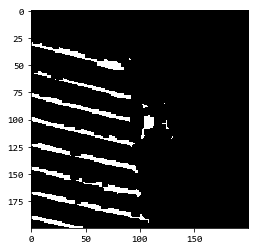

In [3]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(dapeng_ensure)
threshold, mask = cv2.threshold(clahe, 120, 255, cv2.THRESH_BINARY)
threshold, mask = cv2.threshold(mask, 120, 255, cv2.THRESH_OTSU)
kernel = np.ones((2, 2), np.uint8)
erosion = cv2.erode(mask, kernel, iterations=5)
plt.imshow(erosion[partial_vision], cmap="gray")

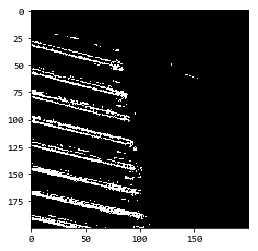

In [4]:
dapeng_hsv = cv2.cvtColor(dapeng, cv2.COLOR_BGR2HSV)
mask1 =cv2.inRange(dapeng_hsv, np.array([10, 40, 140]), np.array([40, 75, 180]))
mask2 = cv2.inRange(dapeng_ensure,np.array([1]),np.array([254]))
mask_and = cv2.bitwise_and(mask1, mask1, mask=mask2)
plt.imshow(mask_and[partial_vision], cmap="gray")

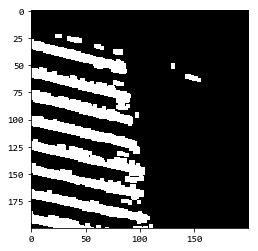

In [5]:
dilation = cv2.dilate(mask_and, kernel, iterations=3)
plt.imshow(dilation[partial_vision], cmap="gray")

In [6]:
_, dilation_contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
_, erosion_contours, _ = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
approx_dilation_contours = [cv2.approxPolyDP(cnt, 1, True) for cnt in dilation_contours]
approx_erosion_contours = [cv2.approxPolyDP(cnt, 1, True) for cnt in erosion_contours]

In [7]:
polygons = []
linestrings = []
points = []
linerings = []
for cnt in approx_erosion_contours:
    assert cnt.shape[1] == 1
    if cnt.shape[0] > 2:
        poly = Polygon(shell=cnt[:, 0, :])
        if poly.is_valid:
            polygons.append(poly)
        else:
            point_list = list(poly.exterior.coords)
            for i in range(len(point_list)-1):
                if i == len(point_list)-1:
                    ls = LineString((point_list[i], point_list[0]))
                else:
                    ls = LineString((point_list[i], point_list[i+1]))
                if ls.is_valid:
                    linestrings.append(ls)
                else:
                    print cnt[:, 0, :]
    elif cnt.shape[0] > 1:
        line = LineString(coordinates=cnt[:, 0, :])
        linestrings.append(line)
    else:
        point = Point(cnt.reshape(2,))
        points.append(point)
multi_polygon = MultiPolygon(polygons)
multi_linestring = MultiLineString(linestrings)
multi_point = MultiPoint(points)

geometry_collection = multi_polygon.union(multi_linestring).union(multi_point)

geometry_collection_wkt = shapely.wkt.dumps(geometry_collection)

ogr_gc = ogr.CreateGeometryFromWkt(geometry_collection_wkt)

使用ipyparallel并行计算

In [8]:
import ipyparallel as ipp
rc = ipp.Client()
v = rc.load_balanced_view()
@v.parallel(block=True)
def get_intersection(contour_ogr_gc):
    contour, ogr_gc = contour_ogr_gc
    import cv2
    from osgeo import ogr
    import numpy as np
    min_area, max_area = 200, 9000
    assert contour.shape[1] == 1
    if min_area < cv2.contourArea(contour) < max_area:
        ring = ogr.Geometry(ogr.wkbLinearRing)
        contour_points = contour[:, 0, :].astype(np.float64)
        for point in contour_points:
            ring.AddPoint(point[0], point[1])
        ring.CloseRings()
        poly = ogr.Geometry(ogr.wkbPolygon)
        poly.AddGeometry(ring)
        if poly.Intersects(ogr_gc):
            return contour

In [9]:
from itertools import repeat

selected_contours = get_intersection.map(zip(approx_dilation_contours, repeat(ogr_gc, len(approx_dilation_contours))))
selected_contours = [x for x in selected_contours if x is not None]

# selected_contours = []
# for cnt in tqdm_notebook(approx_dilation_contours, desc=u"筛选轮廓"):
#     assert cnt.shape[1] == 1
#     min_area, max_area = 200, 9000
#     if min_area < cv2.contourArea(cnt) < max_area:
#         ring = ogr.Geometry(ogr.wkbLinearRing)
#         contour_points = cnt[:, 0, :].astype(np.float64)
#         for point in contour_points:
#             ring.AddPoint(point[0], point[1])
#         ring.CloseRings()
#         poly = ogr.Geometry(ogr.wkbPolygon)
#         poly.AddGeometry(ring)
#         if poly.Intersects(ogr_gc):
#             selected_contours.append(cnt)

len(selected_contours)


1152

In [10]:
dapeng_copy = dapeng.copy()
_ = cv2.drawContours(dapeng_copy, selected_contours, -1, (0, 0, 255), cv2.FILLED)

In [11]:
len(selected_contours)

1152

In [12]:
cv2.imwrite("dapeng_copy.png", dapeng_copy)

True